In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
import glob
np.set_printoptions(precision=4)

In [6]:
frame_dir = '../data/frames/'
n_cam = 4

# cam_dir = [glob.glob(frame_dir+'camera1/*jpg')]
cam_dir = []
for i in range(1,n_cam+1):
    cam_dir.append(glob.glob(frame_dir+'camera'+str(i)+"/*.jpg"))
    cam_dir[i-1].sort()

# [x y z roll pitch yaw]
cam_poses = np.array([
    [20, 20, 12, 0, 0, -2.2],
    [20, -15, 12, 0, 0, 2.2],
    [-20, -20, 12, 0, 0, 0.7],
    [-20, 20, 12, 0, 0, -0.7],
])

# 321 Euler sequence
def euler2dcm(euler):
    from numpy import sin,cos,tan
    phi = euler[0]
    theta = euler[1]
    psi = euler[2]
    
    dcm = np.array([
        [cos(theta)*cos(psi), cos(theta)*sin(psi), -sin(theta)],
        [-cos(phi)*sin(psi)+sin(phi)*sin(theta)*cos(psi), cos(phi)*cos(psi)+sin(phi)*sin(theta)*sin(psi), sin(phi)*cos(theta)],
        [sin(phi)*sin(psi)+cos(phi)*sin(theta)*cos(psi), -sin(phi)*cos(psi)+cos(phi)*sin(theta)*sin(psi), cos(phi)*cos(theta)]
    ])
    return dcm

def cart2hom(point):
    return np.hstack([point,1.0])

def hom2cart(coord):
    return coord[0:-1]

from mpl_toolkits.mplot3d import Axes3D
Multiple View Geometry, Chapter 6, p156 
$$x_{pixel} = P X_{world}$$
$$P = K[R|t] $$

$$ t = -R\tilde{C}$$

$$K = \begin{bmatrix}
f_x & s & c_x\\
    & f_y & c_y\\
    & & 1
\end{bmatrix}
$$

"$R$ is the rotation matrix representing the orientation of the camera coordinate frame, $\tilde{C}$ is the camera's postion in the world frame".

Another Rotation to consider is from the camera model frame used in gazebo to conventional camera frame used in literature.

$$
\begin{bmatrix}
0 & 1 & 0\\
0 & 0 & 1\\
-1 & 0 & 0
\end{bmatrix}
$$

From gazebo camera_info:

D: [0.0, 0.0, 0.0, 0.0, 0.0]

K: [642.0926159343306, 0.0, 1000.5, 0.0, 642.0926159343306, 1000.5, 0.0, 0.0, 1.0]

R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]

P: [642.0926159343306, 0.0, 1000.5, -44.94648311540315, 0.0, 642.0926159343306, 1000.5, 0.0, 0.0, 0.0, 1.0, 0.0]

In [7]:
rot_model2cam = np.array([
        [0, 1, 0],
        [0, 0, 1],
        [-1, 0, 0],        
    ])

def get_cam_in(cam_param):
    fx = cam_param[0]
    fy = cam_param[1]
    cx = cam_param[2]
    cy = cam_param[3]
    s = cam_param[4]
    cam_in = np.array([
        [fx, s, cx],
        [0, fy, cy],
        [0, 0, 1],
    ])
    return cam_in

def get_cam_ex(cam_att):
    rot_world2model = euler2dcm(cam_att)
    rot_model2cam = - np.array([
        [0, 1, 0],
        [0, 0, 1],
        [-1, 0, 0],        
    ])
    
    cam_ex = rot_model2cam @ rot_world2model
    return cam_ex
    
def get_cam_mat(cam_param, cam_pose):
    assert(len(cam_param)==5 and len(cam_pose)==6)
    fx = cam_param[0]
    fy = cam_param[1]
    cx = cam_param[2]
    cy = cam_param[3]
    s = cam_param[4]
    
    pos = cam_pose[0:3]
    euler = cam_pose[3:6]
    
    # intrinsic matrix
    cam_in = np.array([
        [fx, s, cx],
        [0, fy, cy],
        [0, 0, 1],
    ])
    
    # extrinsic matrix
    rot_world2model = euler2dcm(euler)
    rot_model2cam = np.array([
        [0, 1, 0],
        [0, 0, 1],
        [-1, 0, 0],        
    ])
    
    cam_ex = rot_model2cam @ rot_world2model
    cam_mat = cam_in @ cam_ex @ np.block([np.eye(3), -pos.reshape(-1,1)])
    return cam_mat

In [8]:
cam = 0

cam_param = [642.0926, 642.0926, 1000.5, 1000.5,0]
cam_mat = get_cam_mat(cam_param, cam_poses[cam])
# n_frames = min([len(cam_dir[i]) for i in range(n_cam)])
n_frames = len(cam_dir[cam])

drone_coords = []
for i in range(n_frames):
    elapsed = i*0.1
    x = 30*np.sin(2*np.pi*elapsed*1/3)
    y = 15*np.cos(2*np.pi*elapsed*1/3)
    z = 20
    drone_coords.append([x,y,z])
drone_coords = np.array(drone_coords)

drone_coords_hom = np.hstack([drone_coords, np.ones((n_frames,1))])

pixel_coords_hom = (cam_mat @ drone_coords_hom.T).T

pixel_coords = []
for coord in pixel_coords_hom:
    pixel_coords.append([coord[0]/coord[2], coord[1]/coord[2]])
pixel_coords = np.array(pixel_coords)

fig = plt.figure()
plt.plot(pixel_coords[:,0], pixel_coords[:,1], '.')
plt.axis('square')
plt.xlim(0,2000)
plt.ylim(2000,0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [9]:
def draw_box(img, coords):
#     p_h = cam_mat@cart2hom(drone_pos)
#     p_h = p_h/p_h[-1]

#     p = hom2cart(p_h)
    box_size = 10
    color = (255,255,0)
    for row in coords:
        start = (row - [box_size, box_size]).astype(np.int32)
        end = (row + [box_size, box_size]).astype(np.int32)

        thickness = 1
        img = cv.rectangle(img, start, end, color, thickness)

    return img

In [10]:
cam_imgs = cam_dir[cam]
plt.figure(figsize=(15,15))
img = plt.imread(cam_imgs[1])
img_detect = draw_box(img, pixel_coords)
plt.imshow(img_detect)

IndexError: list index out of range

<Figure size 1080x1080 with 0 Axes>

In [11]:
# from matplotlib.animation import FuncAnimation, ArtistAnimation
# from IPython.display import HTML

# fig, ax = plt.subplots(figsize=(15,15))

# ims = []
# cam_imgs = cam_dir[cam]
# for i in range(n_frames):
#     plt.figure(figsize=(15,15))
#     img = plt.imread(cam_imgs[i])
#     img_detect = draw_box(img, pixel_coords)
#     im = ax.imshow(img_detect);
#     ims.append([im])

# ani = ArtistAnimation(fig, ims, interval=100)
# HTML(ani.to_html5_video())

# Calibration
Calibrate camera 4 with using the other camera's location <br>
Known: Cameras' positions (pos), cameras' pixel coords (from reprojection) <br>
Optimize: Camera's orientation (euler) <br>

In [16]:
import casadi as ca
import so3
def euler2dcm_ca(euler):
    from casadi import sin,cos
    phi = euler[0]
    theta = euler[1]
    psi = euler[2]
    
    dcm = ca.SX(3,3)
    dcm[0,0] = cos(theta)*cos(psi)
    dcm[0,1] = cos(theta)*sin(psi)
    dcm[0,2] = -sin(theta)
    dcm[1,0] = -cos(phi)*sin(psi)+sin(phi)*sin(theta)*cos(psi)
    dcm[1,1] = cos(phi)*cos(psi)+sin(phi)*sin(theta)*sin(psi)
    dcm[1,2] = sin(phi)*cos(theta)
    dcm[2,0] = sin(phi)*sin(psi)+cos(phi)*sin(theta)*cos(psi)
    dcm[2,1] = -sin(phi)*cos(psi)+cos(phi)*sin(theta)*sin(psi)
    dcm[2,2] = cos(phi)*cos(theta)
#     dcm = ca.MX([
#         [cos(theta)*cos(psi), cos(theta)*sin(psi), -sin(theta)],
#         [-cos(phi)*sin(psi)+sin(phi)*sin(theta)*cos(psi), cos(phi)*cos(psi)+sin(phi)*sin(theta)*sin(psi), sin(phi)*cos(theta)],
#         [sin(phi)*sin(psi)+cos(phi)*sin(theta)*cos(psi), -sin(phi)*cos(psi)+cos(phi)*sin(theta)*sin(psi), cos(phi)*cos(theta)]
#     ])
    return dcm

In [17]:
def get_cam_mat_ca(cam_param, cam_pos, cam_att):
#     assert(len(cam_param)==5 and len(cam_pose)==6)
    fx = cam_param[0]
    fy = cam_param[1]
    cx = cam_param[2]
    cy = cam_param[3]
    s = cam_param[4]
    
    pos = cam_pos
    euler = cam_att
    
    # intrinsic matrix
    cam_in = ca.SX(3,3)
    cam_in[0,0] = fx
    cam_in[0,1] = s
    cam_in[0,2] = cx
    cam_in[1,1] = fy
    cam_in[1,2] = cy
    cam_in[2,2] = 1
    # extrinsic matrix
    rot_world2model = euler2dcm_ca(euler)
#     rot_world2model = so3.Dcm.from_euler(euler)
    rot_model2cam = ca.SX(np.array([
        [0, 1, 0],
        [0, 0, 1],
        [-1, 0, 0],
    ]))
    
    cam_ex = rot_model2cam @ rot_world2model
    block = ca.SX(3,4)
    block[:,0:3] = cam_ex
    block[:,3] = -(cam_ex @ pos)
    cam_mat = cam_in @ block
    return cam_mat

In [18]:
def get_cam_mat_lie_ca(cam_param, cam_pos, cam_lie):
#     assert(len(cam_param)==5 and len(cam_pose)==6)
    fx = cam_param[0]
    fy = cam_param[1]
    cx = cam_param[2]
    cy = cam_param[3]
    s = cam_param[4]
    
    pos = cam_pos
    w = cam_lie # so3
    
    # intrinsic matrix
    cam_in = ca.SX(3,3)
    cam_in[0,0] = fx
    cam_in[0,1] = s
    cam_in[0,2] = cx
    cam_in[1,1] = fy
    cam_in[1,2] = cy
    cam_in[2,2] = 1
    # extrinsic matrix
#     rot_world2model = euler2dcm_ca(euler)
    rot_world2model = so3.Dcm.exp(w)
    rot_model2cam = ca.SX(np.array([
        [0, 1, 0],
        [0, 0, 1],
        [-1, 0, 0],
    ]))
    
    cam_ex = rot_model2cam @ rot_world2model
    block = ca.SX(3,4)
    block[:,0:3] = cam_ex
    block[:,3] = -(cam_ex @ pos)
    cam_mat = cam_in @ block
    return cam_mat

w = ca.SX.sym('w', 3,1)
dcm = ca.SX.sym('dcm', 3,3)
euler = ca.SX.sym('euler', 3,1)
f_lie2dcm = ca.Function('f_lie2dcm', [w], [so3.Dcm.exp(w)])
f_dcm2lie = ca.Function('f_dcm2lie', [dcm], [so3.Dcm.log(dcm)])
f_euler2dcm = ca.Function('f_euler2dcm', [euler], [so3.Dcm.from_euler(euler)])
f_dcm2euler = ca.Function('f_dcm2euler', [dcm], [so3.Euler.from_dcm(dcm)])
f_lie2euler = ca.Function('f_lie2euler', [w], [so3.Euler.from_dcm(so3.Dcm.exp(w))])
f_euler2lie = ca.Function('f_euler2lie', [euler], [so3.Dcm.log(so3.Dcm.from_euler(euler))])



In [19]:
cam_param_ca = ca.SX.sym('param', 5)
cam_pos_ca = ca.SX.sym('pos', 3)
cam_att_ca = ca.SX.sym('att', 3)
cam_lie_ca = ca.SX.sym('lie', 3)

cam_mat_ca = get_cam_mat_ca(cam_param_ca, cam_pos_ca, cam_att_ca)
cam_mat_lie_ca = get_cam_mat_lie_ca(cam_param_ca, cam_pos_ca, cam_lie_ca)
f_cam_mat = ca.Function('f_cam_mat',[cam_param_ca, cam_pos_ca, cam_att_ca], [cam_mat_ca])
f_cam_mat_lie = ca.Function('f_cam_mat_lie',[cam_param_ca, cam_pos_ca, cam_lie_ca], [cam_mat_lie_ca])

In [20]:
print(f_cam_mat(cam_param, cam_poses[3][0:3], [0,0,0]))
get_cam_mat(cam_param, np.hstack([cam_poses[3][0:3], [0,0,0]]))


[[-1000.5, 642.093, 0, -32851.9], 
 [-1000.5, 0, 642.093, -27715.1], 
 [-1, -0, 0, -20]]


array([[-1.0005e+03,  6.4209e+02,  0.0000e+00, -3.2852e+04],
       [-1.0005e+03,  0.0000e+00,  6.4209e+02, -2.7715e+04],
       [-1.0000e+00,  0.0000e+00,  0.0000e+00, -2.0000e+01]])

In [21]:
cam_mat = get_cam_mat(cam_param, cam_poses[3])
p1_hom = cam_mat @ cart2hom(cam_poses[1][0:3])
p1 = p1_hom[0:2]/p1_hom[2]
p2_hom = cam_mat @ cart2hom(cam_poses[2][0:3])
p2 = p2_hom[0:2]/p2_hom[2]


In [22]:
np.array(f_lie2dcm([0, 0, 0.7]))

array([[ 0.7648, -0.6442,  0.    ],
       [ 0.6442,  0.7648,  0.    ],
       [ 0.    ,  0.    ,  1.    ]])

In [23]:
euler2dcm([0, 0, -0.7])

array([[ 0.7648, -0.6442, -0.    ],
       [ 0.6442,  0.7648,  0.    ],
       [ 0.    , -0.    ,  1.    ]])

In [24]:
cam_mat_ca = get_cam_mat_ca(cam_param, cam_poses[3][0:3], cam_att_ca) 

p1_hom_ca = cam_mat_ca @ cart2hom(cam_poses[1][0:3])
p2_hom_ca = cam_mat_ca @ cart2hom(cam_poses[2][0:3])
p1_ca = p1_hom_ca[0:2]/p1_hom_ca[2]
p2_ca = p2_hom_ca[0:2]/p2_hom_ca[2]

$p_1, p_2$: known pixel coordinates of other cameras <br>
$\hat{p}_1, \hat{p}_2$: estimated pixel coordinates of other cameras <br>
$p = \text{cat}(p_1,p_2)$ <br>
Objective: $||p - \hat{p}||^2$<br>
($\phi,\theta,\psi$) no constraint

In [25]:
# optimization over euler angles
nlp = {'x':cam_att_ca, 'f': ca.norm_2(ca.vertcat(p1_hom-p1_hom_ca, p2_hom-p2_hom_ca))**2, 'g':0}
S = ca.nlpsol('S', 'ipopt', nlp, {
    'print_time': 0,
#         'ipopt': {
#             'sb': 'yes',
#             'print_level': 0,
#             }
})
r = S(x0=[0,0,-0.01], lbg=0, ubg=0)
x_opt = r['x']
print('x_opt: ', x_opt)
print(cam_poses[3][3:6])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equal

In [31]:
# optimization over so3
cam_mat_lie_ca = get_cam_mat_lie_ca(cam_param, cam_poses[3][0:3], cam_lie_ca)

p1_hom_ca = cam_mat_lie_ca @ cart2hom(cam_poses[1][0:3])
p2_hom_ca = cam_mat_lie_ca @ cart2hom(cam_poses[2][0:3])
p1_ca = p1_hom_ca[0:2]/p1_hom_ca[2]
p2_ca = p2_hom_ca[0:2]/p2_hom_ca[2]

nlp = {'x':cam_lie_ca, 'f': ca.norm_2(ca.vertcat(p1_hom-p1_hom_ca, p2_hom-p2_hom_ca))**2, 'g':0}
S = ca.nlpsol('S', 'ipopt', nlp, {
    'print_time': 0,
        'ipopt': {
            # 'sb': 'yes',
            # 'print_level': 1,
            }
})

r = S(x0=[0, 0, 0.1], lbg=0, ubg=0)
x_opt = r['x']
print('x_opt: ', x_opt)
print(cam_poses[3][3:6])

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

: 

In [ ]:
r['f']

DM(3.09333e-10)

## Ray casting
If we take the equation of the camera projection and work our way back
$$x^h = KR[I | -C] X^h$$ 
$$ R^{-1}K^{-1}x^h = X - C $$
$$B_p x^h = r$$

where $B_p$ is the back projection matrix and $r$ is the vector pointing from the camera to the target.
A representation of this ray can be written as $$ C - \lambda \hat{r}$$, where $C$ is the camera's position and $\hat{r}$ is the normalized direction vector. The parameter $\lambda$ tells us the distance between the target and the camera.

In [ ]:
K = get_cam_in(cam_param)
R = get_cam_ex(cam_poses[cam][3:6])
Bp = np.linalg.inv(K @ R)

vec = Bp @ cart2hom(pixel_coords[0,:]).astype('int32') # cast to integer because actual pixels are discrete
vec = vec/np.linalg.norm(vec)
vec

array([-0.904 , -0.2265,  0.3625])

In [ ]:
vec_true = drone_coords[0,:] - cam_poses[cam][0:3]
dist_true = np.linalg.norm(vec_true)
vec_true = vec_true/np.linalg.norm(vec_true)
vec_true

array([-0.9044, -0.2261,  0.3618])

Text(0.5, 0, 'y')

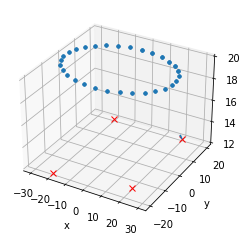

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot3D(drone_coords[:,0], drone_coords[:,1], drone_coords[:,2],'.')
ax.plot3D(cam_poses[:,0], cam_poses[:,1], cam_poses[:,2], 'rx')
ax.quiver(cam_poses[cam,:][0], cam_poses[cam,:][1], cam_poses[cam,:][2], vec[0], vec[1], vec[2])
ax.set_xlabel('x')
ax.set_ylabel('y')

## Range finding
Know target's size and estimate distance to the camera.

IRIS dimension: 550 mm x 550 mm x 110 mm

Let the corners of the square bounding boxes be $p_1, p_2, p_3, \& p_4$, we can cast a ray to each corner, let them be $r_i = \lambda \hat{r}_i - C$. The maximum distance between two adjacent corners should be approximately the maximum dimension of the target. In this case, the motor-to-motor distance of IRIS provides the approximate real distance, which is 550 mm.

We can consider the distance from the camera center to the corners of the bounding box to be equal thus reducing to only one scale factor $\lambda$ for all four rays.
$\lambda$ can then be calculated as 
$$|| (\lambda \hat{r}_1- C) - (\lambda \hat{r}_2 - C) ||= 550$$
$$ \lambda = \frac{550}{||\hat{r}_1-\hat{r}_2||}$$

In [ ]:
dist_true

22.11334438749598

In [ ]:
# suppose the bounding box is 40x40 pixels
dimension = np.array([550, 550, 110])
box_size = np.array([40,40])
